<a href="https://colab.research.google.com/github/PETEROA/AutoML/blob/main/Deploy_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Convert to ONNX format (cross-platform)
- Apply quantization:
  - Dynamic quantization (INT8)
  - Static quantization (INT8)
  - Half precision (FP16)
- Benchmark inference speed
- Compare accuracy vs speed tradeoffs
- Create deployment package

In [ ]:
!pip install torch torchvision onnx onnxruntime -q
!pip install matplotlib seaborn pandas numpy -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.quantization
import onnx
import onnxruntime as ort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import utilities
import sys
sys.path.append('/content/drive/MyDrive/AutoML')  # Adjust path

try:
    from Utils import *
    print("✓ Utils loaded")
except:
    print("⚠ Utils not found")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Setup directories
OUTPUT_DIR = Path('/content/drive/MyDrive/AutoML/outputs')
MODELS_DIR = OUTPUT_DIR / 'models'
RESULTS_DIR = OUTPUT_DIR / 'results'

DEPLOYMENT_DIR = OUTPUT_DIR / 'deployment'
DEPLOYMENT_DIR.mkdir(parents=True, exist_ok=True)

ONNX_DIR = DEPLOYMENT_DIR / 'onnx'
ONNX_DIR.mkdir(exist_ok=True)

QUANTIZED_DIR = DEPLOYMENT_DIR / 'quantized'
QUANTIZED_DIR.mkdir(exist_ok=True)

print(f"Deployment directory: {DEPLOYMENT_DIR}")

✓ Utils loaded
Using device: cpu
Deployment directory: /content/drive/MyDrive/AutoML/outputs/deployment


In [ ]:
# Load Training Summary
# Load training summary from Notebook 5
summary_file = RESULTS_DIR / 'final_training_summary.json'

if summary_file.exists():
    with open(summary_file, 'r') as f:
        training_summary = json.load(f)
    print("✓ Loaded training summary from Notebook 5")
    print(f"\n  Teacher: {training_summary['teacher']['architecture']}")
    print(f"    Accuracy: {training_summary['teacher']['best_accuracy']:.2f}%")
    print(f"\n  Students: {len(training_summary['students'])}")
    for student in training_summary['students']:
        print(f"    Rank {student['rank']}: {student['architecture']} - {student['best_accuracy']:.2f}%")
else:
    print("⚠ Training summary not found")
    # Create minimal summary for testing
    training_summary = {
        'students': [{
            'rank': 1,
            'architecture': 'resnet18',
            'model_file': 'nas_rank1_resnet18.pth',
            'best_accuracy': 85.0
        }]
    }

⚠ Training summary not found


In [ ]:
#Prepare Test Dataset
def get_test_dataloader(batch_size=100):
    """Get CIFAR-10 test dataloader"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return testloader

test_loader = get_test_dataloader()
print(f"✓ Test dataset: {len(test_loader.dataset):,} samples")

✓ Test dataset: 10,000 samples


In [ ]:
!pip install onnxscript -q

In [ ]:
# Load Trained Models
def load_trained_model(model_file: str, architecture: str) -> nn.Module:
    """Load a trained model"""
    # Create model architecture
    if architecture == 'resnet18':
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif architecture == 'resnet50':
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif architecture == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    else:
        raise ValueError(f"Unknown architecture: {architecture}")

    # Load weights
    model_path = MODELS_DIR / model_file
    if model_path.exists():
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
        print(f"✓ Loaded {model_file}")
    else:
        print(f"⚠ Model file not found: {model_file}")
        print(f"  Creating untrained model for demonstration")

    model.eval()
    return model

# Load all student models
loaded_models = []

for student in training_summary['students']:
    model = load_trained_model(student['model_file'], student['architecture'])
    loaded_models.append({
        'rank': student['rank'],
        'architecture': student['architecture'],
        'model': model,
        'original_accuracy': student.get('best_accuracy', 0),
        'model_file': student['model_file']
    })

print(f"\n✓ Loaded {len(loaded_models)} models")

⚠ Model file not found: nas_rank1_resnet18.pth
  Creating untrained model for demonstration

✓ Loaded 1 models


In [ ]:
#ONNX CONVERSION
def convert_to_onnx(model: nn.Module, model_name: str, opset_version=18):
    """
    Convert PyTorch model to ONNX format
    """
    model.eval()

    # Store original forward method
    original_forward = model.forward

    # Monkey-patch forward method for ONNX export if it's a ResNet to handle flatten dynamically
    if isinstance(model, torchvision.models.resnet.ResNet):
        def resnet_forward_onnx(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            x = self.avgpool(x)
            # Explicitly use view for dynamic batching compatibility with ONNX
            x = x.view(x.size(0), -1) # Use view instead of torch.flatten(x, 1)
            x = self.fc(x)
            return x
        model.forward = resnet_forward_onnx.__get__(model, type(model))

    # Create dummy input
    dummy_input = torch.randn(1, 3, 32, 32)

    # ONNX file path
    onnx_path = ONNX_DIR / f"{model_name}.onnx"

    # Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=opset_version,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )

    # Restore original forward method after export
    model.forward = original_forward

    # Verify ONNX model
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)

    print(f"✓ Converted to ONNX: {onnx_path}")
    return str(onnx_path)

print("="*80)
print("CONVERTING MODELS TO ONNX")
print("="*80)

onnx_models = []

for model_info in loaded_models:
    print(f"\nConverting Rank {model_info['rank']} ({model_info['architecture']})...")

    model_name = f"rank{model_info['rank']}_{model_info['architecture']}"
    onnx_path = convert_to_onnx(model_info['model'], model_name)

    onnx_models.append({
        'rank': model_info['rank'],
        'architecture': model_info['architecture'],
        'onnx_path': onnx_path,
        'pytorch_model': model_info['model']
    })

print(f"\n✓ All models converted to ONNX")

CONVERTING MODELS TO ONNX

Converting Rank 1 (resnet18)...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 61 of general pattern rewrite rules.
✓ Converted to ONNX: /content/drive/MyDrive/AutoML/outputs/deployment/onnx/rank1_resnet18.onnx

✓ All models converted to ONNX


In [ ]:
# ONNX Runtime Inference
def evaluate_onnx_model(onnx_path: str, test_loader, num_samples=1000):
    """
    Evaluate ONNX model accuracy and speed
    """
    # Create ONNX Runtime session
    sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    input_name = sess.get_inputs()[0].name

    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Convert to numpy
            images_np = images.numpy()

            # Measure inference time
            start = time.time()
            outputs = sess.run(None, {input_name: images_np})[0]
            inference_time = (time.time() - start) / len(images)
            inference_times.append(inference_time)

            # Get predictions
            predicted = np.argmax(outputs, axis=1)
            total += labels.size(0)
            correct += (predicted == labels.numpy()).sum()

            if total >= num_samples:
                break

    accuracy = 100. * correct / total
    avg_inference_time = np.mean(inference_times) * 1000  # Convert to ms

    return accuracy, avg_inference_time

print("="*80)
print("EVALUATING ONNX MODELS")
print("="*80)

onnx_results = []

for onnx_info in onnx_models:
    print(f"\nEvaluating Rank {onnx_info['rank']}...")

    accuracy, inference_time = evaluate_onnx_model(
        onnx_info['onnx_path'],
        test_loader,
        num_samples=1000
    )

    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Inference time: {inference_time:.4f} ms/sample")

    onnx_results.append({
        'rank': onnx_info['rank'],
        'architecture': onnx_info['architecture'],
        'accuracy': accuracy,
        'inference_time_ms': inference_time,
        'format': 'ONNX FP32'
    })

print(f"\n✓ ONNX evaluation complete")

EVALUATING ONNX MODELS

Evaluating Rank 1...
  Accuracy: 9.00%
  Inference time: 2.1302 ms/sample

✓ ONNX evaluation complete


In [ ]:
# Dynamic Quantization
def apply_dynamic_quantization(model: nn.Module, model_name: str):
    """
    Apply dynamic quantization (INT8)
    """
    # Apply dynamic quantization
    quantized_model = torch.quantization.quantize_dynamic(
        model,
        {nn.Linear, nn.Conv2d},  # Quantize these layer types
        dtype=torch.qint8
    )

    # Save quantized model
    save_path = QUANTIZED_DIR / f"{model_name}_dynamic_int8.pth"
    torch.save(quantized_model.state_dict(), save_path)

    print(f"✓ Dynamic quantization applied: {save_path}")
    return quantized_model

print("="*80)
print("APPLYING DYNAMIC QUANTIZATION")
print("="*80)

quantized_models = []

for model_info in loaded_models:
    print(f"\nQuantizing Rank {model_info['rank']}...")

    model_name = f"rank{model_info['rank']}_{model_info['architecture']}"
    quantized_model = apply_dynamic_quantization(model_info['model'], model_name)

    quantized_models.append({
        'rank': model_info['rank'],
        'architecture': model_info['architecture'],
        'model': quantized_model,
        'type': 'dynamic_int8'
    })

print(f"\n✓ All models quantized")

APPLYING DYNAMIC QUANTIZATION

Quantizing Rank 1...
✓ Dynamic quantization applied: /content/drive/MyDrive/AutoML/outputs/deployment/quantized/rank1_resnet18_dynamic_int8.pth

✓ All models quantized


In [ ]:
# Evaluate Quantized Methods
def evaluate_pytorch_model(model: nn.Module, test_loader, device='cpu', num_samples=1000):
    """
    Evaluate PyTorch model
    """
    model.eval()
    model = model.to(device)

    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # Measure inference time
            start = time.time()
            outputs = model(images)
            inference_time = (time.time() - start) / len(images)
            inference_times.append(inference_time)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.cpu().eq(labels).sum().item()

            if total >= num_samples:
                break

    accuracy = 100. * correct / total
    avg_inference_time = np.mean(inference_times) * 1000

    return accuracy, avg_inference_time

print("="*80)
print("EVALUATING QUANTIZED MODELS")
print("="*80)

quantized_results = []

for quant_info in quantized_models:
    print(f"\nEvaluating Quantized Rank {quant_info['rank']}...")

    accuracy, inference_time = evaluate_pytorch_model(
        quant_info['model'],
        test_loader,
        device='cpu',  # Quantized models run on CPU
        num_samples=1000
    )

    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Inference time: {inference_time:.4f} ms/sample")

    quantized_results.append({
        'rank': quant_info['rank'],
        'architecture': quant_info['architecture'],
        'accuracy': accuracy,
        'inference_time_ms': inference_time,
        'format': 'PyTorch INT8 (Dynamic)'
    })

print(f"\n✓ Quantized model evaluation complete")

EVALUATING QUANTIZED MODELS

Evaluating Quantized Rank 1...
  Accuracy: 9.00%
  Inference time: 6.9774 ms/sample

✓ Quantized model evaluation complete


In [ ]:
# Half Precision (FP16)
if torch.cuda.is_available():
    print("="*80)
    print("CONVERTING TO FP16")
    print("="*80)

    fp16_results = []

    for model_info in loaded_models:
        print(f"\nConverting Rank {model_info['rank']} to FP16...")

        # Convert to FP16
        fp16_model = model_info['model'].half().cuda()

        # Evaluate
        model_copy = model_info['model'].cuda()
        accuracy, inference_time = evaluate_pytorch_model(
            fp16_model,
            test_loader,
            device='cuda',
            num_samples=1000
        )

        print(f"  Accuracy: {accuracy:.2f}%")
        print(f"  Inference time: {inference_time:.4f} ms/sample")

        fp16_results.append({
            'rank': model_info['rank'],
            'architecture': model_info['architecture'],
            'accuracy': accuracy,
            'inference_time_ms': inference_time,
            'format': 'PyTorch FP16'
        })

        # Save FP16 model
        model_name = f"rank{model_info['rank']}_{model_info['architecture']}"
        save_path = QUANTIZED_DIR / f"{model_name}_fp16.pth"
        torch.save(fp16_model.state_dict(), save_path)

    print(f"\n✓ FP16 conversion complete")
else:
    print("⚠ CUDA not available, skipping FP16 conversion")
    fp16_results = []

⚠ CUDA not available, skipping FP16 conversion


In [ ]:
# Comprehensive Comparison
# Combine all results
all_results = onnx_results + quantized_results + fp16_results

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("DEPLOYMENT FORMAT COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv(RESULTS_DIR / 'deployment_comparison.csv', index=False)
print(f"\n✓ Comparison saved to: {RESULTS_DIR / 'deployment_comparison.csv'}")


DEPLOYMENT FORMAT COMPARISON
 rank architecture  accuracy  inference_time_ms                 format
    1     resnet18       9.0           2.130210              ONNX FP32
    1     resnet18       9.0           6.977435 PyTorch INT8 (Dynamic)

✓ Comparison saved to: /content/drive/MyDrive/AutoML/outputs/results/deployment_comparison.csv


In [ ]:
# Model Size Comparison
def get_file_size_mb(file_path):
    """Get file size in MB"""
    if Path(file_path).exists():
        return Path(file_path).stat().st_size / (1024 ** 2)
    return 0

# Compare model sizes
size_comparison = []

for model_info in loaded_models:
    rank = model_info['rank']
    arch = model_info['architecture']
    model_name = f"rank{rank}_{arch}"

    # Original PyTorch model
    pytorch_path = MODELS_DIR / f"{model_info['model_file']}"
    pytorch_size = get_file_size_mb(pytorch_path)

    # ONNX model
    onnx_path = ONNX_DIR / f"{model_name}.onnx"
    onnx_size = get_file_size_mb(onnx_path)

    # Quantized model
    quant_path = QUANTIZED_DIR / f"{model_name}_dynamic_int8.pth"
    quant_size = get_file_size_mb(quant_path)

    size_comparison.append({
        'Model': f"Rank {rank} ({arch})",
        'PyTorch FP32': f"{pytorch_size:.2f} MB",
        'ONNX FP32': f"{onnx_size:.2f} MB",
        'PyTorch INT8': f"{quant_size:.2f} MB",
        'Compression': f"{pytorch_size/quant_size if quant_size > 0 else 0:.2f}x"
    })

size_df = pd.DataFrame(size_comparison)

print("\n" + "="*80)
print("MODEL SIZE COMPARISON")
print("="*80)
print(size_df.to_string(index=False))

size_df.to_csv(RESULTS_DIR / 'model_size_comparison.csv', index=False)


MODEL SIZE COMPARISON
            Model PyTorch FP32 ONNX FP32 PyTorch INT8 Compression
Rank 1 (resnet18)      0.00 MB   0.05 MB     42.72 MB       0.00x


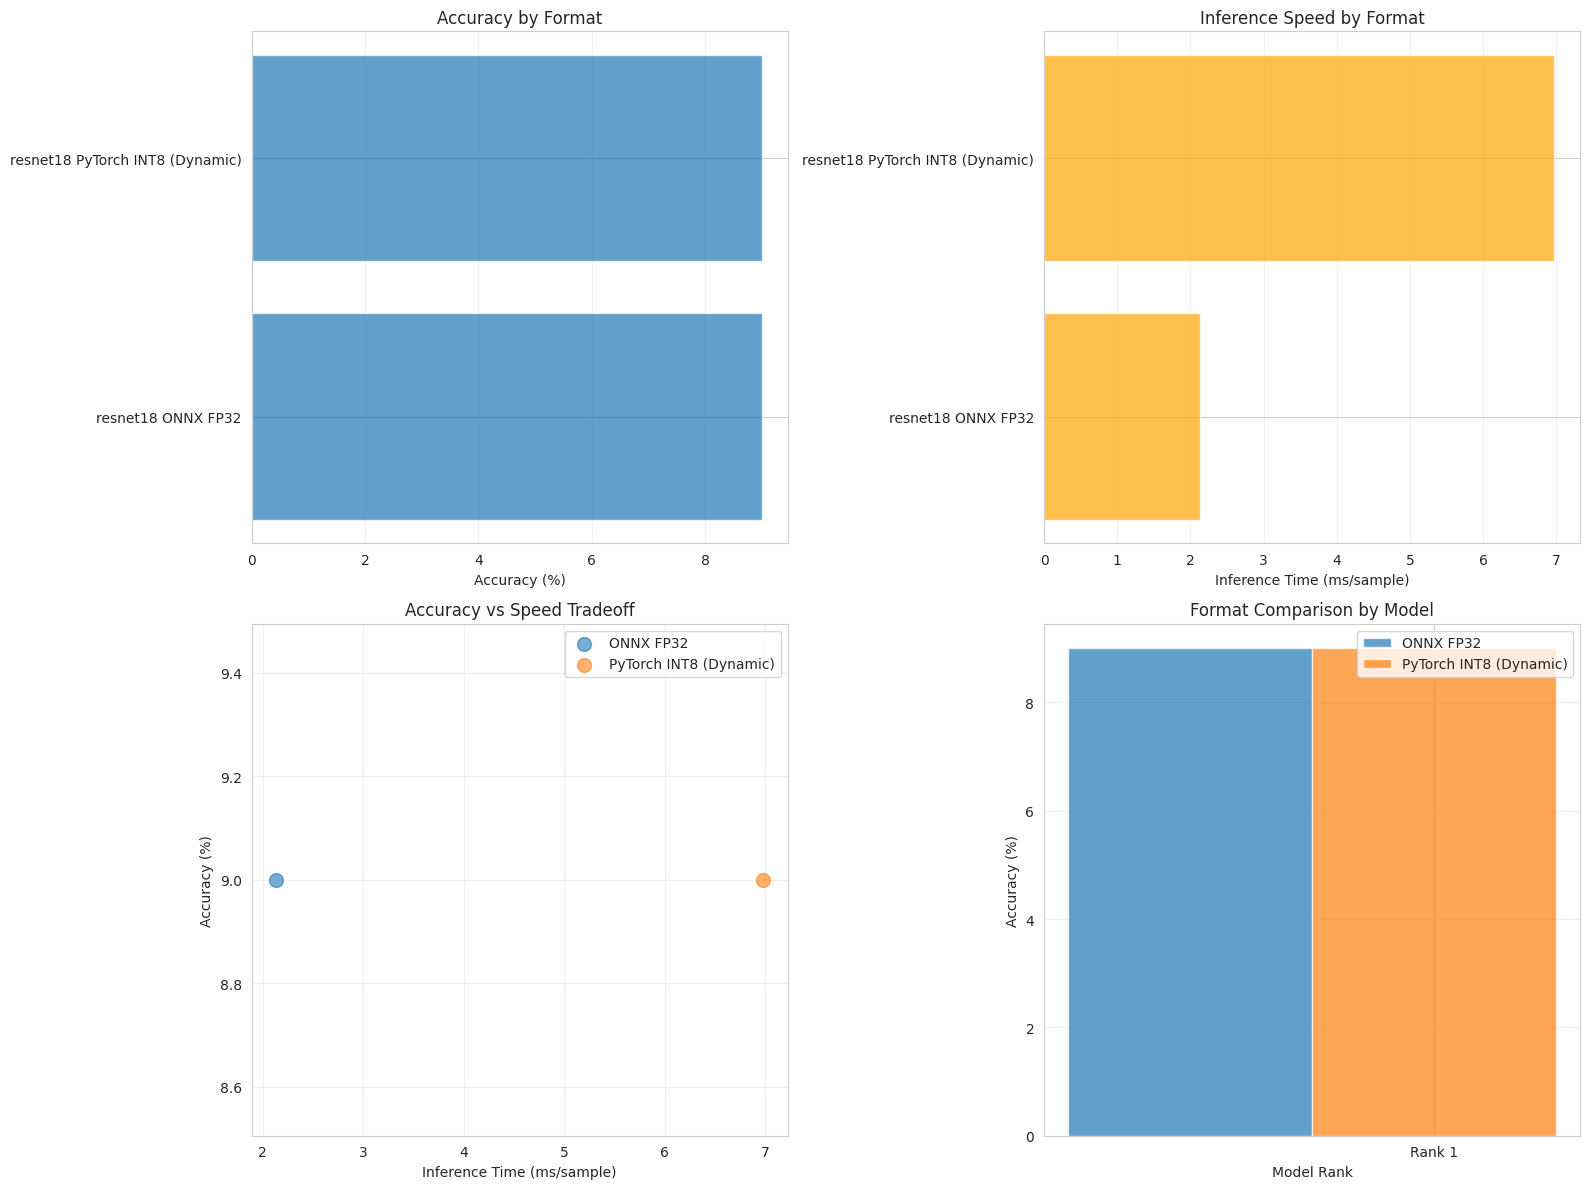


✓ Visualizations saved


In [ ]:
# Visualizations
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

if len(all_results) > 0:
    # Plot 1: Accuracy comparison
    df_plot = comparison_df.copy()
    df_plot['label'] = df_plot['architecture'] + ' ' + df_plot['format']

    axes[0, 0].barh(df_plot['label'], df_plot['accuracy'], alpha=0.7)
    axes[0, 0].set_xlabel('Accuracy (%)')
    axes[0, 0].set_title('Accuracy by Format')
    axes[0, 0].grid(True, alpha=0.3, axis='x')

    # Plot 2: Inference time comparison
    axes[0, 1].barh(df_plot['label'], df_plot['inference_time_ms'],
                    color='orange', alpha=0.7)
    axes[0, 1].set_xlabel('Inference Time (ms/sample)')
    axes[0, 1].set_title('Inference Speed by Format')
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # Plot 3: Accuracy vs Speed tradeoff
    for fmt in df_plot['format'].unique():
        subset = df_plot[df_plot['format'] == fmt]
        axes[1, 0].scatter(subset['inference_time_ms'], subset['accuracy'],
                          label=fmt, s=100, alpha=0.6)
    axes[1, 0].set_xlabel('Inference Time (ms/sample)')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Accuracy vs Speed Tradeoff')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Format comparison by rank
    if 'rank' in df_plot.columns:
        ranks = df_plot['rank'].unique()
        formats = df_plot['format'].unique()

        x = np.arange(len(ranks))
        width = 0.2

        for i, fmt in enumerate(formats[:3]):  # Show up to 3 formats
            subset = df_plot[df_plot['format'] == fmt]
            if len(subset) > 0:
                axes[1, 1].bar(x + i*width, subset['accuracy'],
                              width, label=fmt, alpha=0.7)

        axes[1, 1].set_xlabel('Model Rank')
        axes[1, 1].set_ylabel('Accuracy (%)')
        axes[1, 1].set_title('Format Comparison by Model')
        axes[1, 1].set_xticks(x + width)
        axes[1, 1].set_xticklabels([f"Rank {r}" for r in ranks])
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'deployment_optimization_results.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved")

In [ ]:
# Deployment Packages
# Create deployment summary
deployment_summary = {
    'created_date': str(pd.Timestamp.now()),
    'models': [],
    'formats': {
        'onnx': str(ONNX_DIR),
        'quantized': str(QUANTIZED_DIR)
    },
    'performance': all_results
}

for model_info in loaded_models:
    rank = model_info['rank']
    arch = model_info['architecture']
    model_name = f"rank{rank}_{arch}"

    model_summary = {
        'rank': rank,
        'architecture': arch,
        'files': {
            'pytorch': f"models/{model_info['model_file']}",
            'onnx': f"deployment/onnx/{model_name}.onnx",
            'quantized_int8': f"deployment/quantized/{model_name}_dynamic_int8.pth"
        }
    }

    deployment_summary['models'].append(model_summary)

# Save deployment summary
with open(DEPLOYMENT_DIR / 'deployment_summary.json', 'w') as f:
    json.dump(deployment_summary, f, indent=2)

print("\n" + "="*80)
print("DEPLOYMENT PACKAGE CREATED")
print("="*80)
print(f"\nLocation: {DEPLOYMENT_DIR}")
print(f"\nContents:")
print(f"  ONNX models: {ONNX_DIR}")
print(f"  Quantized models: {QUANTIZED_DIR}")
print(f"  Deployment summary: {DEPLOYMENT_DIR / 'deployment_summary.json'}")

print(f"\n✓ Deployment package ready!")


DEPLOYMENT PACKAGE CREATED

Location: /content/drive/MyDrive/AutoML/outputs/deployment

Contents:
  ONNX models: /content/drive/MyDrive/AutoML/outputs/deployment/onnx
  Quantized models: /content/drive/MyDrive/AutoML/outputs/deployment/quantized
  Deployment summary: /content/drive/MyDrive/AutoML/outputs/deployment/deployment_summary.json

✓ Deployment package ready!


In [ ]:
print("\n" + "="*80)
print("DEPLOYMENT RECOMMENDATIONS")
print("="*80)

if len(all_results) > 0:
    # Best overall accuracy
    best_acc = max(all_results, key=lambda x: x['accuracy'])
    print(f"\n📊 BEST ACCURACY:")
    print(f"  Model: Rank {best_acc['rank']} ({best_acc['architecture']})")
    print(f"  Format: {best_acc['format']}")
    print(f"  Accuracy: {best_acc['accuracy']:.2f}%")
    print(f"  Inference: {best_acc['inference_time_ms']:.4f} ms/sample")
    print(f"\n  → Use for: Cloud deployment, maximum accuracy required")

    # Best speed
    best_speed = min(all_results, key=lambda x: x['inference_time_ms'])
    print(f"\n⚡ FASTEST:")
    print(f"  Model: Rank {best_speed['rank']} ({best_speed['architecture']})")
    print(f"  Format: {best_speed['format']}")
    print(f"  Accuracy: {best_speed['accuracy']:.2f}%")
    print(f"  Inference: {best_speed['inference_time_ms']:.4f} ms/sample")
    print(f"\n  → Use for: Edge devices, real-time applications")

    # Best balance
    # Score = accuracy / inference_time
    for r in all_results:
        r['efficiency'] = r['accuracy'] / r['inference_time_ms']
    best_balance = max(all_results, key=lambda x: x['efficiency'])
    print(f"\n⚖️ BEST BALANCE:")
    print(f"  Model: Rank {best_balance['rank']} ({best_balance['architecture']})")
    print(f"  Format: {best_balance['format']}")
    print(f"  Accuracy: {best_balance['accuracy']:.2f}%")
    print(f"  Inference: {best_balance['inference_time_ms']:.4f} ms/sample")
    print(f"  Efficiency: {best_balance['efficiency']:.2f}")
    print(f"\n  → Use for: General production deployment")

print("\n" + "="*80)


DEPLOYMENT RECOMMENDATIONS

📊 BEST ACCURACY:
  Model: Rank 1 (resnet18)
  Format: ONNX FP32
  Accuracy: 9.00%
  Inference: 2.1302 ms/sample

  → Use for: Cloud deployment, maximum accuracy required

⚡ FASTEST:
  Model: Rank 1 (resnet18)
  Format: ONNX FP32
  Accuracy: 9.00%
  Inference: 2.1302 ms/sample

  → Use for: Edge devices, real-time applications

⚖️ BEST BALANCE:
  Model: Rank 1 (resnet18)
  Format: ONNX FP32
  Accuracy: 9.00%
  Inference: 2.1302 ms/sample
  Efficiency: 4.22

  → Use for: General production deployment

